In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os

import warnings
warnings.filterwarnings('ignore')

print(tf.config.list_physical_devices('GPU'))

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# PATHS
IMG_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image'
MSK_PATH = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

True
True


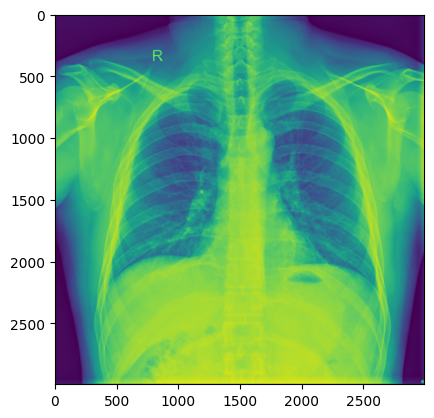

In [ ]:
sample_img = cv2.imread('/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image/1000.png',0)
plt.imshow(sample_img)

In [ ]:
sample_img.shape

(2995, 2993)

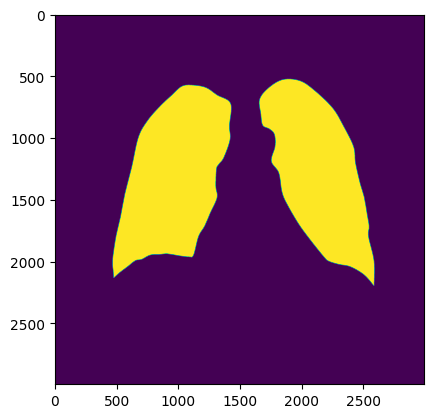

In [ ]:
sample_msk = cv2.imread('/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask/1000.png',0)
plt.imshow(sample_msk)

In [ ]:
sample_msk.shape

(2995, 2993)

Data Generation and processing

In [ ]:
img_path = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image'
msk_path = '/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/mask'

In [ ]:
img_files, msk_files = sorted(os.listdir(img_path)),sorted(os.listdir(msk_path))

train_img_files,val_img_files,train_msk_files,val_msk_files = train_test_split(img_files,msk_files,test_size=0.2,random_state=1)

In [ ]:
img_datagen = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect',
)

msk_datagen = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect',
)

batch_size = 16
target_size = (256,256)

def image_mask_generator(image_files,mask_files,batch_size):
    while True:

        combined = list(zip(image_files, mask_files))
        random.shuffle(combined)
        image_files, mask_files = zip(*combined)

        for i in range(0,len(image_files),batch_size):
            batch_img_files = image_files[i:i+batch_size]
            batch_msk_files = mask_files[i:i+batch_size]

            msk_batch = []
            img_batch = []

            for img_file, msk_file in zip(batch_img_files,batch_msk_files):
                img = cv2.imread(os.path.join(img_path,img_file), cv2.IMREAD_COLOR)
                img = cv2.resize(img,target_size)/255.

                msk = cv2.imread(os.path.join(msk_path,msk_file), cv2.IMREAD_GRAYSCALE)
                msk = cv2.resize(msk,target_size)/255.
                msk = (msk>0).astype(np.uint8)
                msk = np.expand_dims(msk, axis = -1)

                img_batch.append(img)
                msk_batch.append(msk)

            img_batch = np.array(img_batch)
            msk_batch = np.array(msk_batch)

            # seed = np.random.randint(1,1000)
            # img_batch = next(img_datagen.flow(img_batch, batch_size = batch_size, seed=seed, shuffle = False))
            # msk_batch = next(msk_datagen.flow(msk_batch, batch_size = batch_size, seed=seed, shuffle = False))

            yield img_batch, msk_batch

Testing DataGenerator

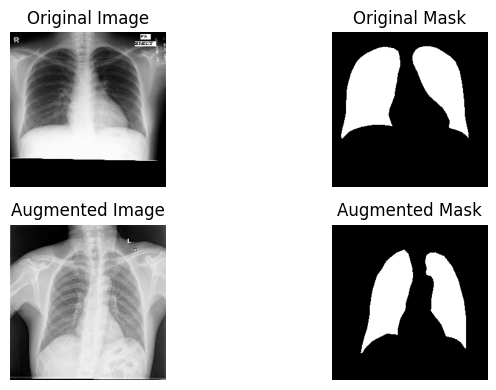

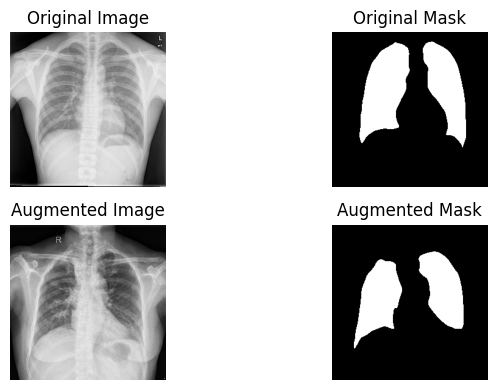

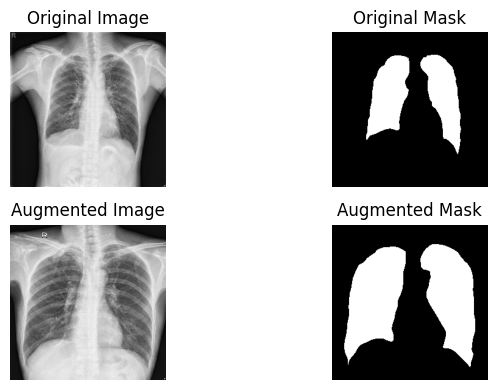

In [ ]:
def visualize_generator(generator, image_files, mask_files, num_samples=3):

    img_batch, msk_batch = next(generator)

    for i in range(num_samples):
        img = cv2.imread(os.path.join(img_path, image_files[i]), cv2.IMREAD_COLOR)
        img = cv2.resize(img, target_size) / 255.0

        msk = cv2.imread(os.path.join(msk_path, mask_files[i]), cv2.IMREAD_GRAYSCALE)
        msk = cv2.resize(msk, target_size) / 255.0
        msk = (msk > 0).astype(np.uint8)

        aug_img = img_batch[i]
        aug_msk = msk_batch[i]

        plt.figure(figsize=(8, 4))

        plt.subplot(2, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(2, 2, 2)
        plt.imshow(msk, cmap="gray")
        plt.title("Original Mask")
        plt.axis("off")

        plt.subplot(2, 2, 3)
        plt.imshow(aug_img)
        plt.title("Augmented Image")
        plt.axis("off")

        plt.subplot(2, 2, 4)
        plt.imshow(aug_msk.squeeze(), cmap="gray")
        plt.title("Augmented Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

test_generator = image_mask_generator(train_img_files, train_msk_files, batch_size=8)

visualize_generator(test_generator, train_img_files, train_msk_files)


In [ ]:
train_generator = image_mask_generator(train_img_files, train_msk_files, batch_size)
valid_generator = image_mask_generator(val_img_files, val_msk_files, batch_size)

In [ ]:
def unet(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)  # Downsample

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)  # Downsample

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)  # Downsample

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization

    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)  # Upsample
    merge6 = layers.concatenate([up6, conv3])  # Concatenate with the corresponding encoder block
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization

    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)  # Upsample
    merge7 = layers.concatenate([up7, conv2])  # Concatenate with the corresponding encoder block
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization

    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)  # Upsample
    merge8 = layers.concatenate([up8, conv1])  # Concatenate with the corresponding encoder block
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv8)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
import tensorflow as tf

def jaccard_index(y_true, y_pred, smooth=100):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (total + smooth)

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

input_shape = (256,256,3)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = unet(input_shape, 1)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', dice_coefficient, jaccard_index])


In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_img_files) // batch_size,
    validation_steps=len(val_img_files) // batch_size,
    epochs=150,
    callbacks=[checkpoint],
)


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8131 - dice_coefficient: 0.6182 - jaccard_index: 0.4598 - loss: 0.4684
Epoch 1: val_dice_coefficient improved from -inf to 0.42706, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.8152 - dice_coefficient: 0.6208 - jaccard_index: 0.4626 - loss: 0.4640 - val_accuracy: 0.2965 - val_dice_coefficient: 0.4271 - val_jaccard_index: 0.2721 - val_loss: 29.0853
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9624 - dice_coefficient: 0.8677 - jaccard_index: 0.7669 - loss: 0.1182
Epoch 2: val_dice_coefficient improved from 0.42706 to 0.50827, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9625 - dice_coefficient: 0.8679 - jaccard_index: 0.7673 - loss: 0.1180 - val_accuracy: 0.5734 - val_dice_coefficient: 0.5083 - val_jaccard_index: 0.3413 - val_loss: 7.6399
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9724 - dice_coefficient

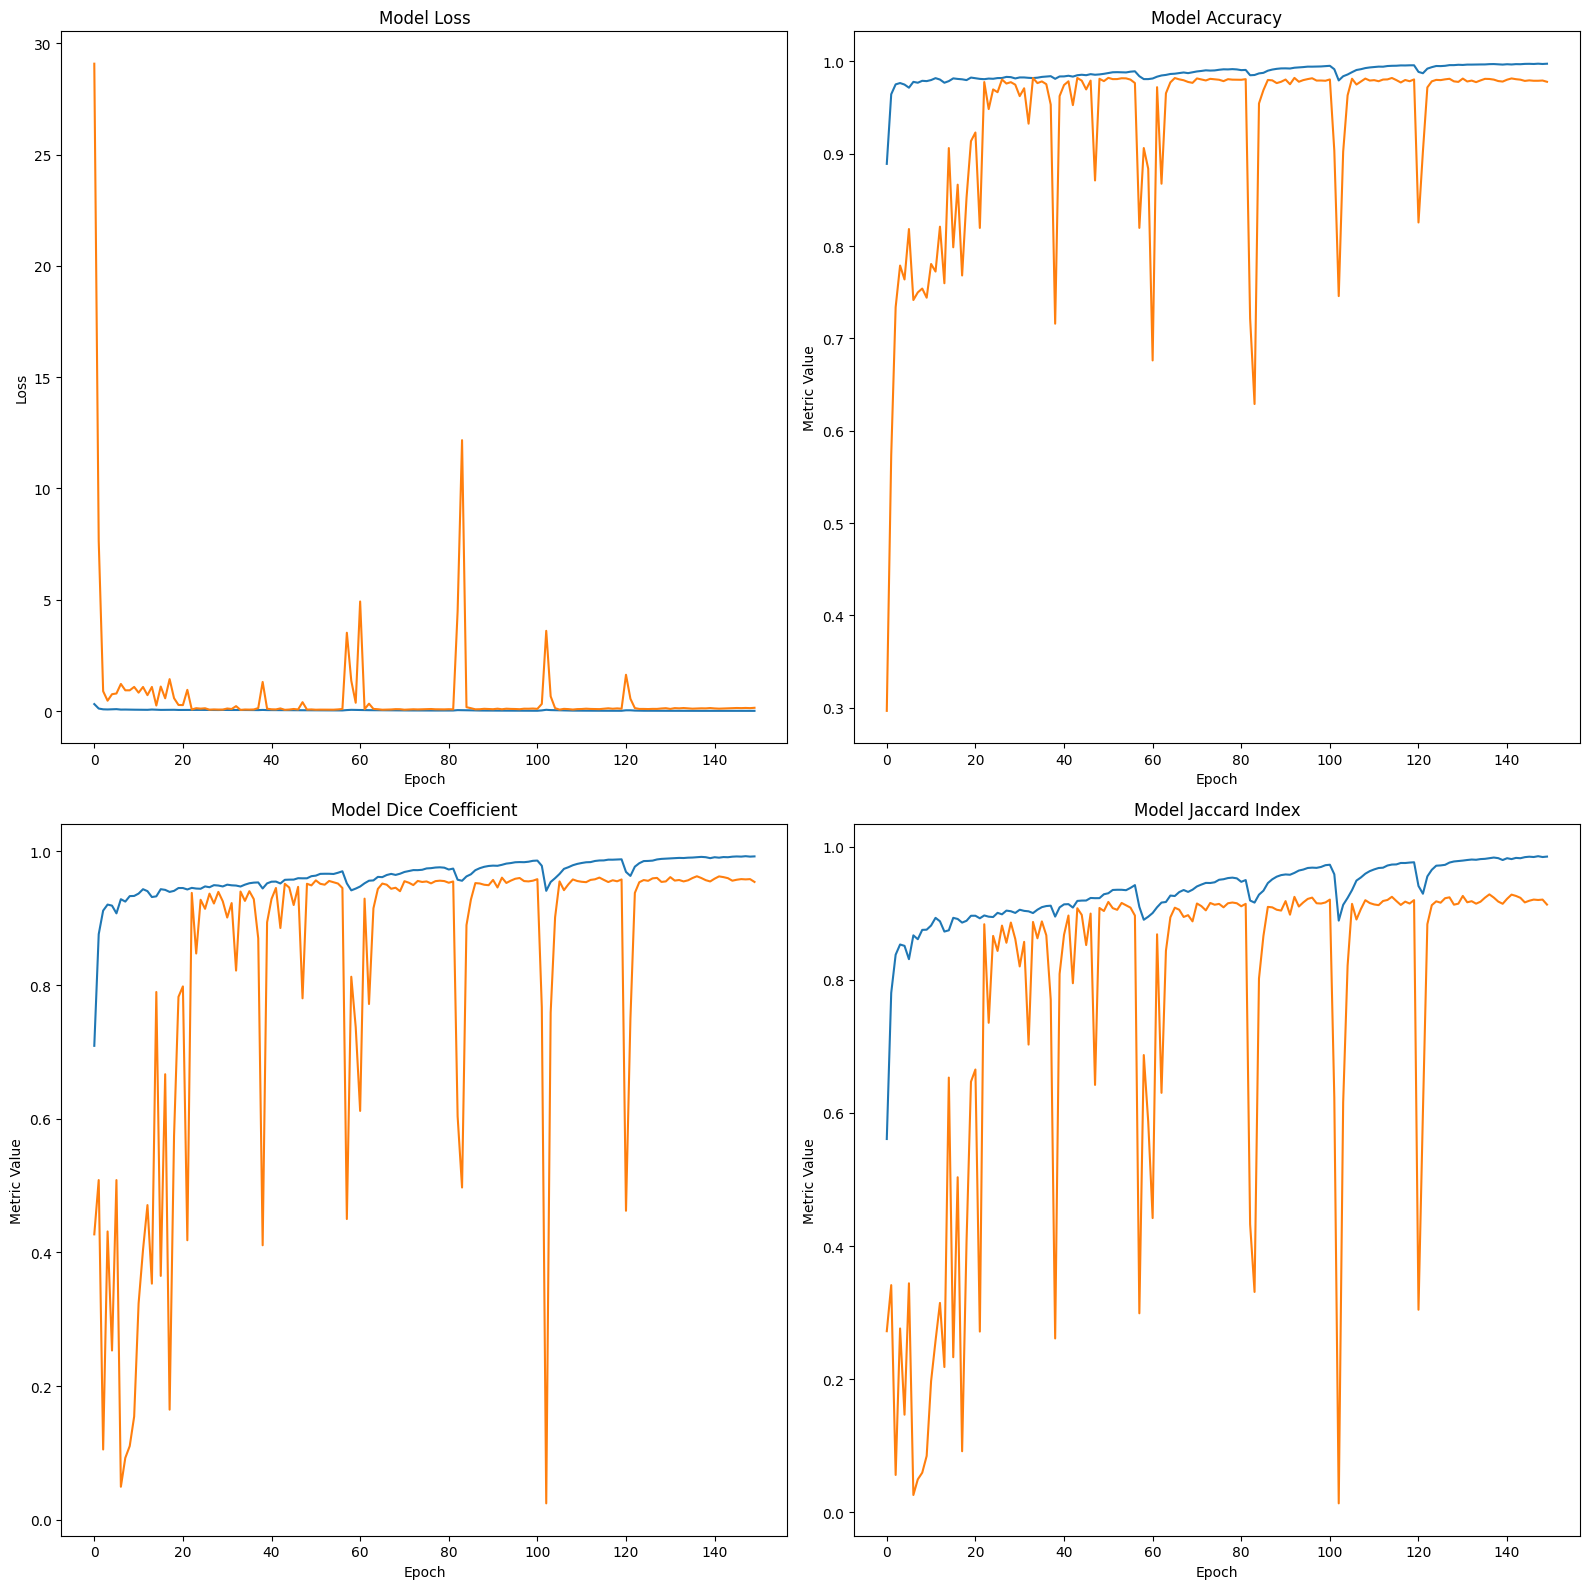

In [ ]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(223)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(224)
plt.plot(history.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(history.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


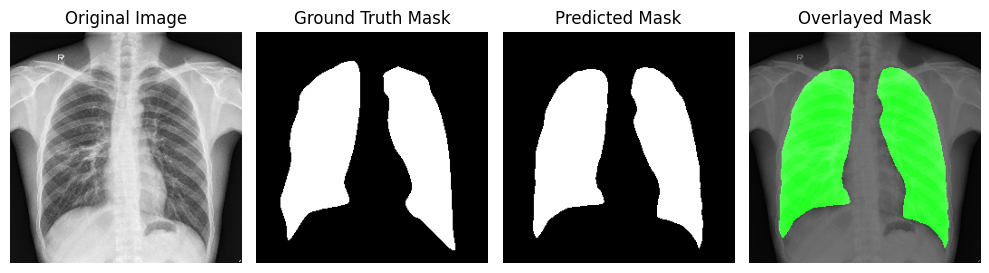

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


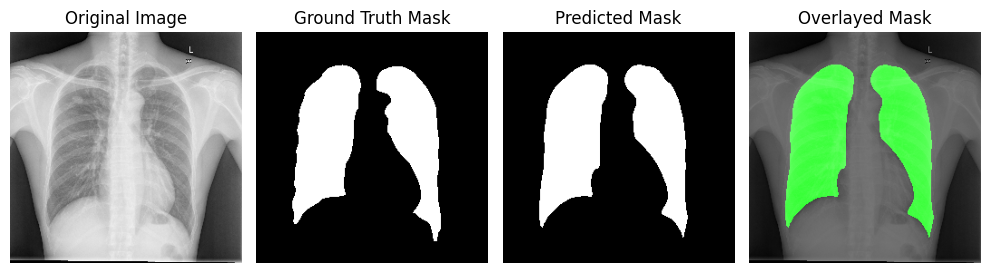

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


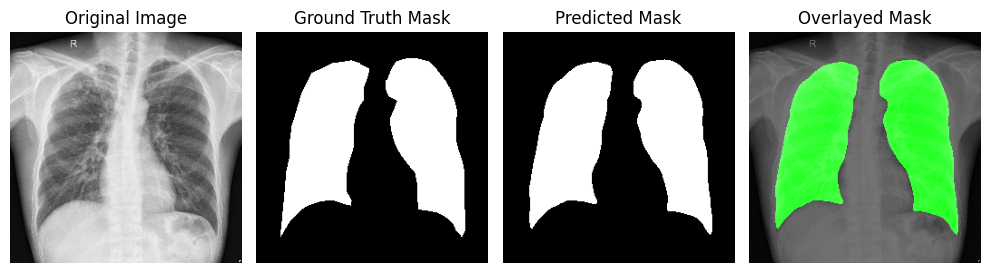

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os

model = tf.keras.models.load_model('best_model.keras', custom_objects={'dice_coefficient': dice_coefficient, 'jaccard_index': jaccard_index})

def overlay_mask(image, mask, alpha=0.5):
    mask = np.squeeze(mask)
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 1] = (mask * 255).astype(np.uint8)
    overlay = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)
    return overlay

def test_model(model, image_files, mask_files, num_samples=3):
    for i in range(num_samples):
        img = cv2.imread(os.path.join(img_path, image_files[i]), cv2.IMREAD_COLOR)
        img = cv2.resize(img, target_size) / 255.0
        input_img = np.expand_dims(img, axis=0)

        true_mask = cv2.imread(os.path.join(msk_path, mask_files[i]), cv2.IMREAD_GRAYSCALE)
        true_mask = cv2.resize(true_mask, target_size) / 255.0
        true_mask = (true_mask > 0).astype(np.uint8)

        predicted_mask = model.predict(input_img)[0]
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        overlayed_img = overlay_mask(img, predicted_mask)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(overlayed_img)
        plt.title("Overlayed Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

test_model(model, val_img_files, val_msk_files)
